In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv('data/data.csv')
#df = pd.read_csv(data.csv)

# Ejercicio 1

In [4]:
counts = df['target'].value_counts()
percentages = df['target'].value_counts(normalize=True) * 100
pd.DataFrame({'cantidades': counts, 'porcentajes': percentages})

,cantidades,porcentajes
target,,
0,343,68.6
1,157,31.4


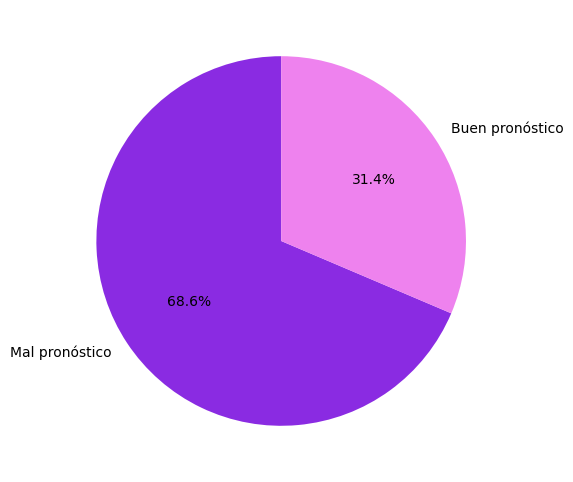

In [21]:
#Grafico de torta
plt.figure(figsize=(10, 6))
plt.pie(percentages, labels=['Mal pronóstico', 'Buen pronóstico'], autopct='%1.1f%%', startangle=90, colors= ['#8A2BE2', 'violet'])
plt.show()

Notamos que estamos ante un dataset algo desbalanceado, por lo que separaremos los datos de forma estratificada.

In [ ]:
# Separación train-test estratificada

def train_test_split(df,train_size=0.8): 
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    n = df.shape[0]  #cantidad de filas
    cantPos = df['target'].sum() #positivas son 1, negativas son 0
    #columna 'target' tiene valores 0 y 1
    proporcion = cantPos / n

    cant_en_train = int(n*train_size)
    cant_en_validacion = n - cant_en_train

    res = []
    cant_positivas = int(proporcion * cant_en_validacion)
    cant_negativas = cant_en_validacion - cant_positivas

    contador_positivos, contador_negativos = 0, 0
    for index, value in enumerate(df['target']):
        if value == 0:
            contador_negativos += 1
            res.append(index)

        if contador_negativos == cant_negativas:
            break
    for index, value in enumerate(df['target']):
        if value == 1:
            contador_positivos += 1
            res.append(index)

        if contador_positivos == cant_positivas:
            break

    df_dev = df.loc[~df.index.isin(res)].reset_index(drop=True)
    df_eval = df.loc[res].reset_index(drop=True)
    return df_dev,df_eval

In [ ]:
# Separamos 70% para entrenamiento y 30% para evaluación

df_dev , df_eval =  train_test_split(df,0.7)


# Ejercicio 2

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score , average_precision_score
from sklearn.model_selection import cross_val_predict

In [ ]:
# Datos de entrenamiento
X_train = df_dev.drop(columns=['target']).values

y_train = df_dev['target'].values



# Lo usamos al final para predecir el AUC_ROC
X_eval   = df_eval.drop(columns=['target']).values

y_eval   =  df_eval['target'].values

## 2.1


In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=51)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=51)

## 2.2


In [ ]:
scoring = ['accuracy', 'roc_auc', 'average_precision']

#Dado que el dataset está algo desbalanceado, usamos StratifiedKFold
skf = StratifiedKFold(n_splits=5)

cv_results = cross_validate(tree_clf, X_train, y_train, cv = skf, scoring = scoring, return_train_score = True)

predicted_labels = cross_val_predict(tree_clf, X_train, y_train, cv = skf)

df_resultados_ej_2_2 = pd.DataFrame({key: cv_results[key] for key in list(cv_results.keys())[2:]})
df_resultados_ej_2_2.index = df_resultados_ej_2_2.index + 1 # asi el indice del df se correponde con el k-Fold
metricas_globales = [accuracy_score(y_train, predicted_labels), np.nan, roc_auc_score(y_train, predicted_labels), np.nan,average_precision_score(y_train, predicted_labels), np.nan]


df_resultados_ej_2_2.loc['Promedio'] = df_resultados_ej_2_2.mean()
df_resultados_ej_2_2.loc['Global'] = metricas_globales

df_resultados_ej_2_2 = df_resultados_ej_2_2.fillna("No Corresponde")

df_resultados_ej_2_2

,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_average_precision,train_average_precision
1,0.671429,0.832143,0.612689,0.862305,0.449379,0.74501
2,0.657143,0.817857,0.656723,0.787435,0.460012,0.662661
3,0.657143,0.846429,0.623580,0.871656,0.416415,0.717895
4,0.628571,0.846429,0.562973,0.859967,0.350321,0.771605
5,0.700000,0.853571,0.518939,0.81617,0.371775,0.691897
Promedio,0.662857,0.839286,0.594981,0.839506,0.409580,0.717814
Global,0.662857,No Corresponde,0.584280,No Corresponde,0.366941,No Corresponde


## 2.3

In [ ]:
alturas = [3, 5, None]
criterios = ["gini", "entropy"]
resultados = {}

for criterio in criterios:
    for altura in alturas:

        tree = DecisionTreeClassifier(max_depth = altura, criterion = criterio, random_state = 51)

        cv_results_grid = cross_validate(tree, X_train, y_train, cv = skf, scoring = 'accuracy', return_train_score = True)

        accuracy_train = cv_results_grid['train_score'].mean()

        accuracy_test =  cv_results_grid['test_score'].mean()



        resultados[(altura, criterio)] = (accuracy_train,accuracy_test)

results_df = pd.DataFrame(resultados.values(), index=resultados.keys(), columns=['Accuracy (training)', 'Accuracy (testing)'])

results_df

,,Accuracy (training),Accuracy (testing)
3,gini,0.839286,0.662857
5,gini,0.939286,0.654286
NaN,gini,1.000000,0.637143
3,entropy,0.800000,0.645714
5,entropy,0.912143,0.642857
NaN,entropy,1.000000,0.625714


## 2.4
Notamos que en Test el criterio de corte Gini da siempre mejor que entropy para cualquier altura.
Sera porque entropy tiende a producir arboles mas equilibrados y nuestro data set esta desbalanceado?

Asimismo tambien vemos que a medida que aumenta la altura del arbol, decae el rendimiento en el test set y aumenta en el train set, independientemente del criterio de corte utilizado.

# Ejercicio 3

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import scipy
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [ ]:
n_iter_search = 50    # Esto es la cantidad de configuraciones que pruebo en cada modelo

## Árboles de decisión

In [ ]:
# Hay que revisar en la documentacion del modelo cada parametro y usar una distribucion con los valores mas probables
# Las listas son interpretadas como distribuciones uniformes discretas

# Comento los parámetros que generan errores
dist_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': scipy.stats.randint(1,40), #puede ser float
    'min_samples_split': scipy.stats.randint(2,20), #puede ser float
    'min_samples_leaf': scipy.stats.randint(1,20),
    'max_features': scipy.stats.randint(1,50),
    'random_state': [42],
    'max_leaf_nodes': scipy.stats.randint(2,len(X_train)),
   
}

tree = DecisionTreeClassifier()
random_search = RandomizedSearchCV(estimator=tree, param_distributions=dist_params, scoring='roc_auc', cv=skf,  n_iter=n_iter_search)
random_search.fit(X_train, y_train)

mejor_modelo_arbol = random_search.best_estimator_
mejor_score_arbol = random_search.best_score_
print("Mejor modelo:", mejor_modelo_arbol,'\n')
print("Mejor score AUCROC:", mejor_score_arbol)

Mejor modelo: DecisionTreeClassifier(criterion='entropy', max_depth=11, max_features=27,
                       max_leaf_nodes=20, min_samples_leaf=14,
                       min_samples_split=12, random_state=42) 

Mejor score AUCROC: 0.6719696969696969


In [ ]:
semilla = np.random.seed(57)
# funciones para definir probabilidades ordenadamente
def entero_random(desde,hasta,seed):
    np.random.seed(seed)
    return scipy.stats.randint(desde, hasta)


def uniforme(desde,hasta,seed):
    np.random.seed(seed)
    return scipy.stats.uniform(desde, hasta)

def priors_uniforme(seed):
    from scipy.stats import uniform

    np.random.seed(seed)

    sample = uniform.rvs(0,1)

    return [sample,1-sample]



    

## KNN (k-vecinos más cercanos)

In [ ]:
dist_params = {
    'n_neighbors': entero_random(1,30,semilla),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': entero_random(1,50 ,semilla),
    'p': entero_random(1, 5,semilla),
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],

   
}

knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(estimator=knn, param_distributions=dist_params, scoring='roc_auc', cv=skf, n_iter=n_iter_search)

# Normalizo los datos para knn
X_train_normalized = preprocessing.normalize(X_train.T).T
random_search.fit(X_train_normalized, y_train)

mejor_modelo_knn = random_search.best_estimator_
mejor_score_knn = random_search.best_score_
print("Mejor modelo:", mejor_modelo_knn,'\n')
print("Mejor score AUCROC:", mejor_score_knn)

Mejor modelo: KNeighborsClassifier(algorithm='brute', leaf_size=19, metric='euclidean',
                     n_neighbors=22, p=4, weights='distance') 

Mejor score AUCROC: 0.7729166666666667


## SVM (Support vector machine)

In [ ]:
dist_params = {
    'C': uniforme(0, 10,semilla),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': entero_random(1, 6,semilla),
    'gamma': ['scale', 'auto' ],
    'coef0': uniforme(0, 1,semilla),
    'shrinking': [True, False],
    'probability': [True, False],
    'tol': uniforme(0, 0.1,semilla),
    'cache_size': entero_random(1, 1000,semilla),
}

svm = SVC()
random_search = RandomizedSearchCV(estimator=svm, param_distributions=dist_params, scoring='roc_auc', cv=skf, n_iter=n_iter_search)
random_search.fit(X_train, y_train)

mejor_modelo_svm = random_search.best_estimator_
mejor_score_svm = random_search.best_score_
print("Mejor modelo:", mejor_modelo_svm,'\n')
print("Mejor score AUCROC:", mejor_score_svm)

Mejor modelo: SVC(C=4.6980864737757075, cache_size=230, coef0=0.5093216374056697, degree=2,
    kernel='poly', probability=True, tol=0.005043091821726409) 

Mejor score AUCROC: 0.8901515151515152


## LDA (Linear discriminant analysis)

In [ ]:
# Hubo bastantes errores con los parámetros

dist_params = {
    'solver': ['svd'], # el solver de cuadrados minimos con svd da la solucion optima
    
    'priors': [priors_uniforme(semilla)],

    'tol': uniforme(0, 1,semilla)  
}


lda = LinearDiscriminantAnalysis()
random_search = RandomizedSearchCV(estimator=lda, param_distributions=dist_params, scoring='roc_auc', cv=skf, n_iter=n_iter_search,random_state=42)
random_search.fit(X_train, y_train)

mejor_modelo_lda = random_search.best_estimator_
mejor_score_lda = random_search.best_score_
print("Mejor modelo:", mejor_modelo_lda,'\n')
print("Mejor score AUCROC:", mejor_score_lda)

Mejor modelo: LinearDiscriminantAnalysis(priors=[0.5164253676552213, 0.4835746323447787],
                           tol=0.3745401188473625) 

Mejor score AUCROC: 0.8111742424242425


## Naïve Bayes

In [ ]:
dist_params = {
    'var_smoothing': uniforme(0, 1,semilla),
    'priors': [priors_uniforme(semilla)]
}

nb = GaussianNB()
random_search = RandomizedSearchCV(estimator=nb, param_distributions=dist_params, scoring='roc_auc', cv=skf, n_iter=n_iter_search)
random_search.fit(X_train, y_train)

mejor_modelo_naive = random_search.best_estimator_
mejor_score_naive = random_search.best_score_
print("Mejor modelo:", mejor_modelo_naive,'\n')
print("Mejor score AUCROC:", mejor_score_naive)

Mejor modelo: GaussianNB(priors=[0.5253261058030917, 0.4746738941969083],
           var_smoothing=0.01441733076189966) 

Mejor score AUCROC: 0.8498106060606061


# Ejercicio 4

## 4.1. Curvas de compejidad

In [ ]:
from sklearn.base import clone
import matplotlib.pyplot as plt

def graficar_curva_complejidad (model, X, y, param_name, param_values, model_name, ax = None):
    
    # Listas para almacenar los puntajes medios de entrenamiento y prueba
    mean_train_scores = []
    mean_test_scores = []

    for param_value in param_values:
        # Crea una copia del modelo con los mismos valores de parámetro 
        model_new = clone(model)

        # Establece el valor del parámetro
        model_new.set_params(**{param_name: param_value})

        # Realiza la validación cruzada
        cv_results = cross_validate(model_new, X, y, cv=skf, scoring=['roc_auc'], return_train_score=True)

        # Calcula y almacena los puntajes medios de entrenamiento y prueba
        mean_train_scores.append(cv_results['train_roc_auc'].mean())
        mean_test_scores.append(cv_results['test_roc_auc'].mean())

    if ax is None:
        fig, ax = plt.subplots()
    
    mean_train_error = [1 - score for score in mean_train_scores]
    mean_test_error = [1 - score for score in mean_test_scores]

    #plt.figure(figsize=(10, 6))
    #ax.subplots(figsize=(8, 6))
    ax.plot(param_values, mean_train_error, color='tab:blue', marker='o', label='Training score')
    ax.plot(param_values, mean_test_error, color='tab:orange', marker='o', label='Test score')
    ax.set_title(f"Curva de complejidad de {model_name}")
    ax.set_xlabel(param_name)
    ax.set_ylabel('Error')
    ax.legend()
    #plt.show()

    return ax

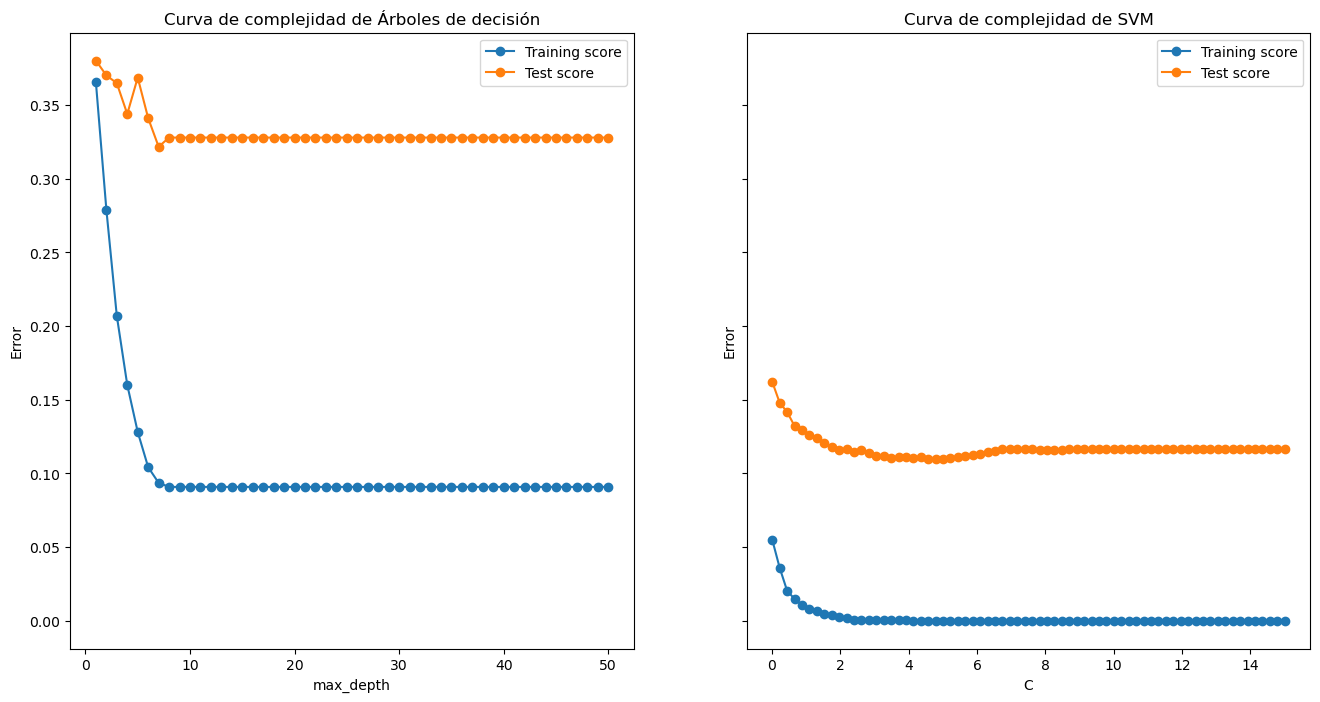

In [ ]:
# Graficamos las curvas de complejidad

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)
#fig.suptitle('Curvas de complejidad', fontsize=16)
graficar_curva_complejidad (mejor_modelo_arbol, X_train, y_train, 'max_depth', range(1, 51), "Árboles de decisión", ax[0])
graficar_curva_complejidad (mejor_modelo_svm, X_train, y_train, 'C', np.linspace(0.01, 15, 70), "SVM", ax[1])

plt.show()


C
* hay un valor (optimo) a partir del cual aprende ruido (minimo gap)
* aumenta training score, disminuyte el test score
* aprende ruido, más varianza
* mas sesgo
* con mayor C, mas posibilidad de "error", margenes más anchos



max_depth
* se vuelven constantes la de train y set, a partir de ...
* poca varianza de un modelo a otro (?)
gap entre performance entre train y set (15 puntos): sesgado. gap constante para cada modelo
* aumento max_depth, baja varianza, aumenta sesgo (hasta un
* no aprende nada nuevo respecto al anterior


Notar que los máximos deberían coincidir máso menos con los hallados en el 3.

## 4.2

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay
#from sklearn.model_selection import learning_curve

def plot_learning_curves(models,modelParams):

        fig, ax = plt.subplots(nrows=1, ncols=len(models), figsize=(16, 8), sharey=True)
        
        if not isinstance(ax, np.ndarray):
            ax = np.array([ax])
            
        common_params = {
            "X": X_train,
            "y": y_train,
            "train_sizes": np.linspace(0.1, 1.0, 100),
            "cv": skf,
            "score_type": "both",
            "n_jobs": 4,
            "line_kw": {"marker": "o"},
            "std_display_style": "fill_between",
            "score_name": "roc_auc",
        }
        for ax_idx, estimator in enumerate(models):
            LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
            handles, label = ax[ax_idx].get_legend_handles_labels()
            ax[ax_idx].legend(handles[:2], ["Training score", "Test score"])
            ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}{modelParams[ax_idx]}")

        plt.show()

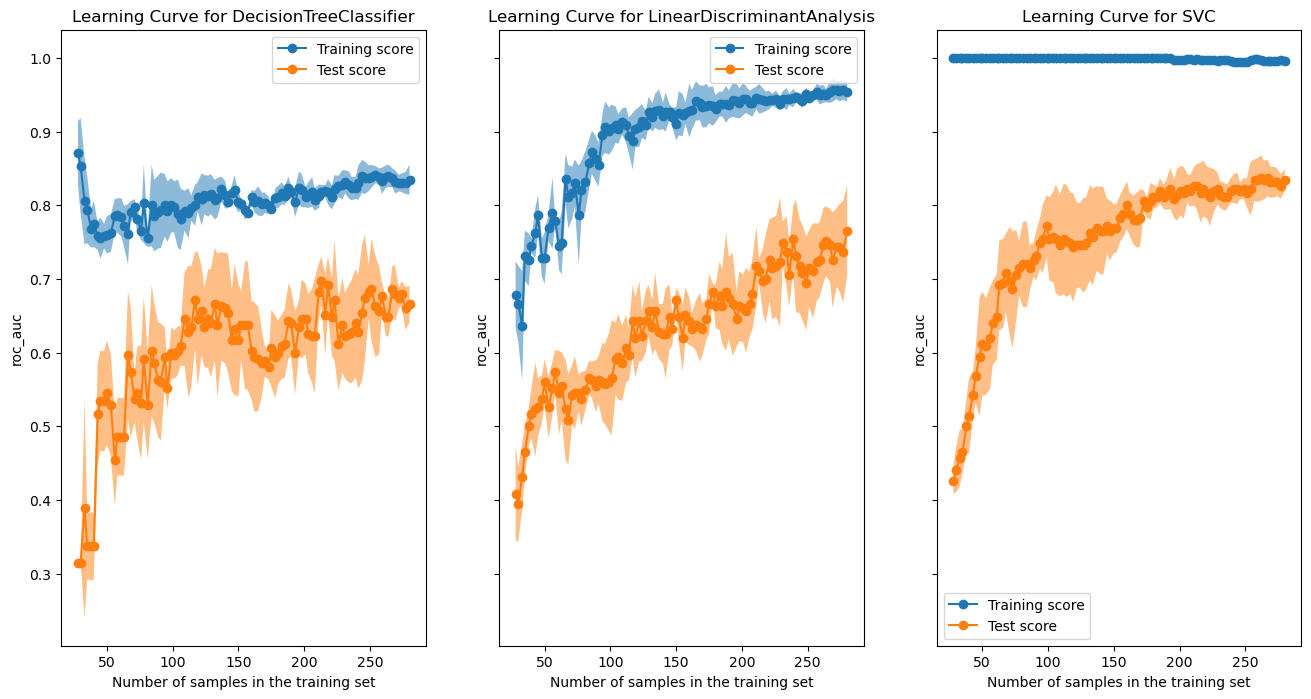

In [ ]:
#Graficamos el mejor encontrado para cada uno
mejores = [mejor_modelo_arbol, mejor_modelo_lda, mejor_modelo_svm]
params = ["" , "", ""]

plot_learning_curves (mejores, params)

Tree: parece que hay lugar para mejorar el modelo con más datos de entrenamiento
LDA: parece haber alcanzado una cota, aunque ...
SVM: parece haber alcanzado una cota de forma asintótica, por lo que es poco probable que se consigan mejoras significativas con más datos de entrenamiento (por suerte nos quedamos con el 30% para validacion, porque más datos de entrenamiento no parecen mejorar el roc_auc significativamente)


### Curvas de nuestros modelos top 3

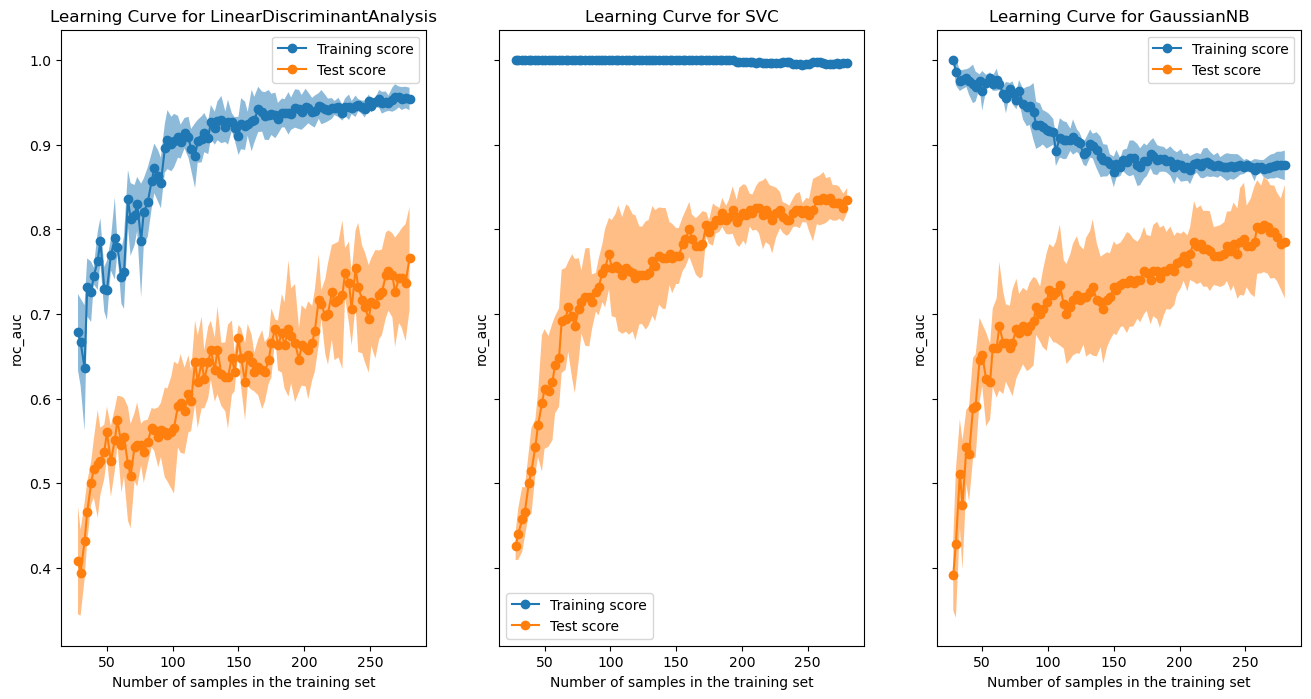

In [ ]:
plot_learning_curves([mejor_modelo_lda,mejor_modelo_svm,mejor_modelo_naive],params)

### Por curiosidad

Estudiamos como varia la curva de aprendizaje en funcion de los hyperparametros centrales de cada algoritmo

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
svm_1 = SVC(C = 1,kernel = 'poly')

svm_5 = SVC(C = 5, kernel = 'poly')

svm_10 = SVC(C = 10 , kernel = 'poly')

svms = [svm_1,svm_5,svm_10]

Svm_params = [" C = 1"," C = 5 "," C = 10"]



tree_3 = DecisionTreeClassifier(max_depth=3, random_state=51)

tree_7 = DecisionTreeClassifier(max_depth=7, random_state=51)

tree_inf = DecisionTreeClassifier(max_depth= None, random_state=51)

arboles = [tree_3,tree_7,tree_inf]

arbol_params = [" h = 3"," h = 7"," h = None"]



rnd_200 = RandomForestClassifier(n_estimators=200)

rnd_10 = RandomForestClassifier(n_estimators=10)

rnd_20 = RandomForestClassifier(n_estimators = 20)

bosques = [rnd_200,rnd_10,rnd_20]

bosque_params = [" n = 200"," n = 10"," n = 20"]

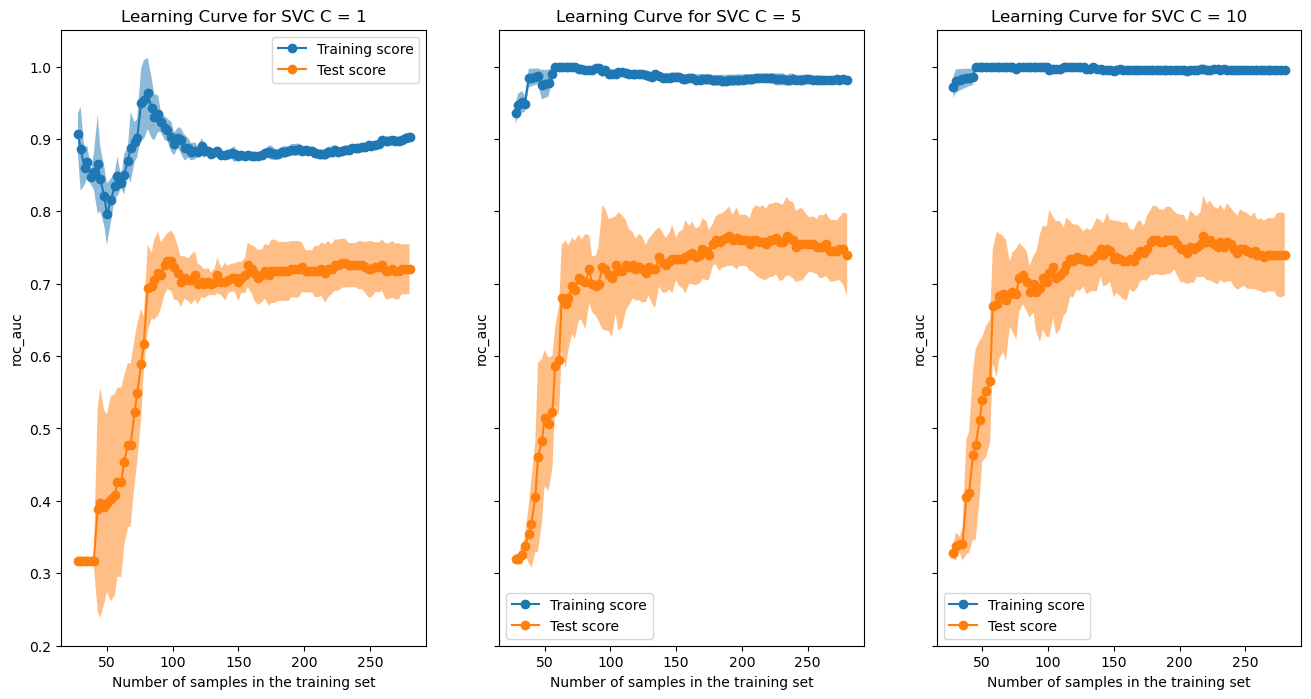

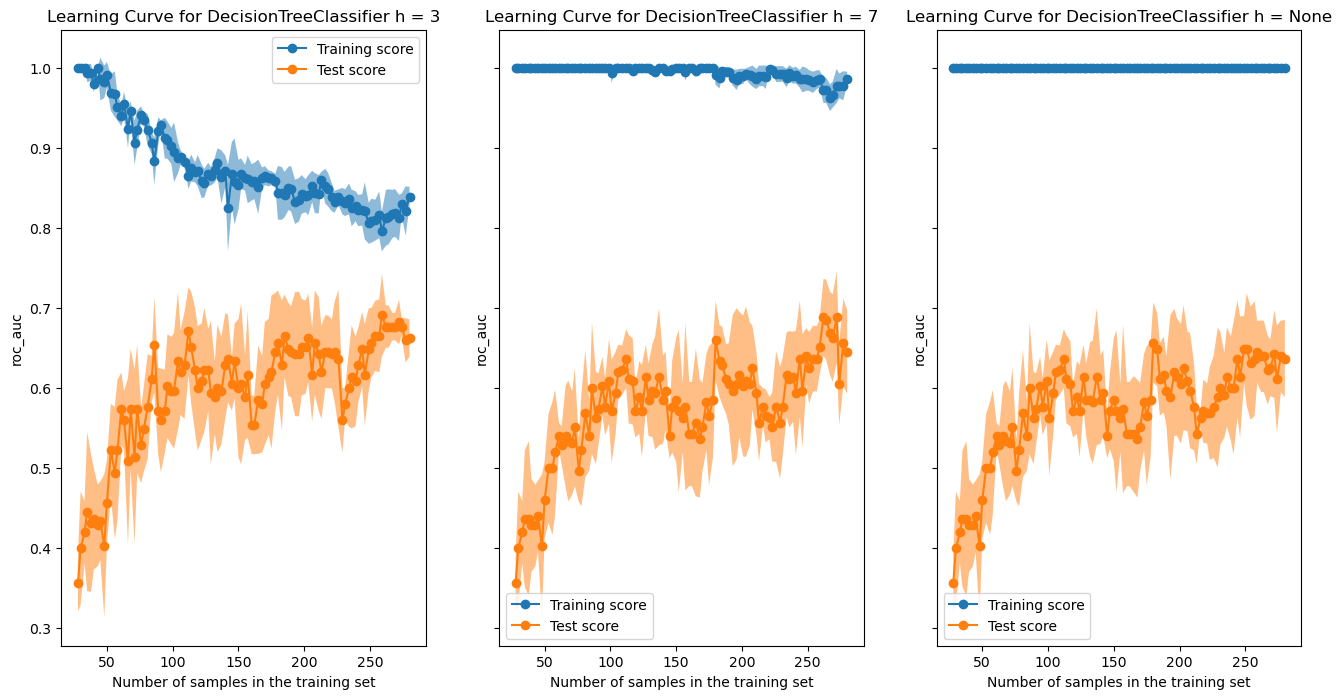

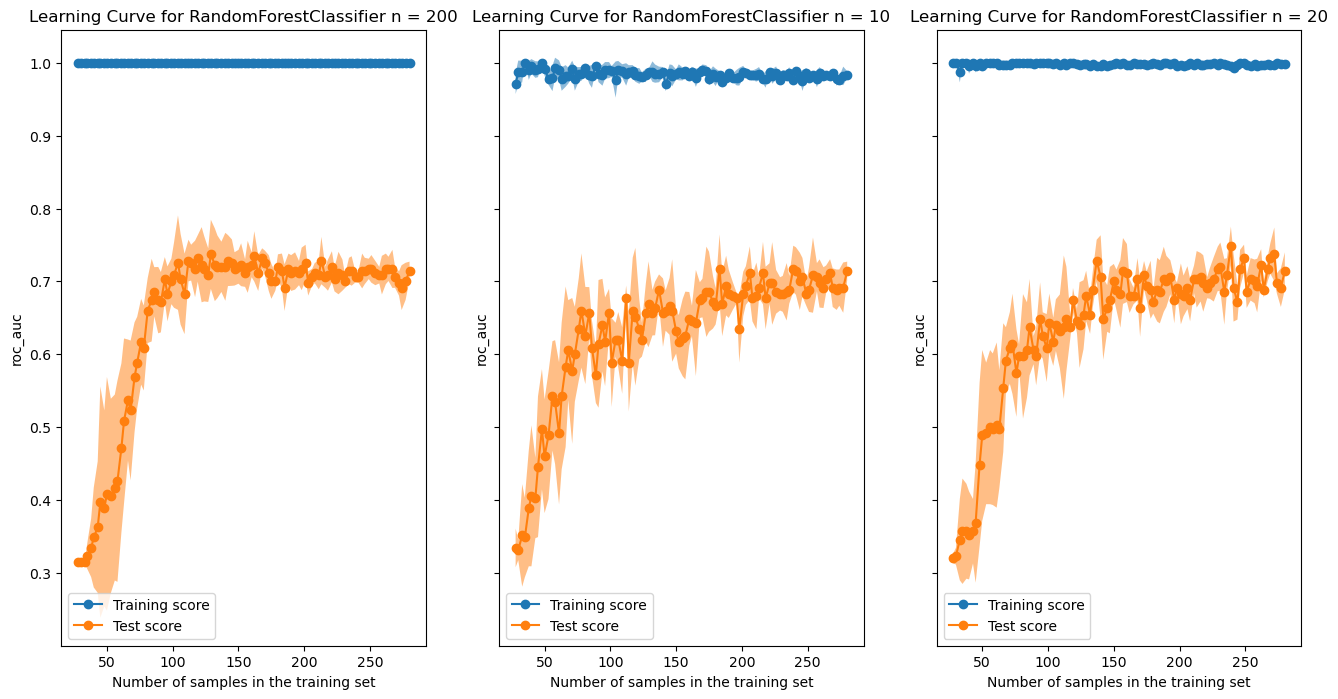

In [ ]:
plot_learning_curves(svms, Svm_params)

plot_learning_curves(arboles, arbol_params)

plot_learning_curves(bosques, bosque_params)

In [ ]:
from sklearn.metrics import roc_auc_score

def valores_curva_aprendizaje (model):
    print(model)
    # Divide los datos en train y set
    df_train_curva , df_test_curva =  train_test_split(df_dev,train_size=0.8)

    X_train_curva = df_train_curva.drop(columns=['target']).values
    y_train_curva = df_train_curva['target'].values
    X_test_curva   = df_test_curva.drop(columns=['target']).values
    y_test_curva   =  df_test_curva['target'].values

    train_sizes = (np.linspace(0.1, 1.0, 50) * len(X_train_curva)).round().astype(int)
    train_scores = []
    test_scores = []

    for train_size in train_sizes:
        # Nos quedamos con las primeras train_size filas
        X_train_subset = X_train_curva[:train_size]
        y_train_subset = y_train_curva[:train_size]

        # Entrenamos el modelo en el subconjunto
        model.fit(X_train_subset, y_train_subset)

        # Calculamos los scores en ambos subjconjuntos y los agregamos a la lista
        train_score = roc_auc_score(y_train_subset, model.predict(X_train_subset))
        test_score = roc_auc_score(y_test_curva, model.predict(X_test_curva))

        train_scores.append(train_score)
        test_scores.append(test_score)
    
    return train_scores, test_scores, train_sizes

In [ ]:
def plot_learning_curves2(models,modelParams):

        fig, ax = plt.subplots(nrows=1, ncols=len(models), figsize=(16, 8), sharey=True)

        if not isinstance(ax, np.ndarray):
            ax = np.array([ax])
        
        for ax_idx, model in enumerate(models):
          
            train_scores, test_scores, train_sizes = valores_curva_aprendizaje (model)
            
            ax[ax_idx].plot(train_sizes, train_scores, label='Training score')
            ax[ax_idx].plot(train_sizes, test_scores, label='Test score')
            
            ax[ax_idx].legend(["Training Score", "Test Score"])
            ax[ax_idx].set_title(f"Learning Curve for {model.__class__.__name__}{modelParams[ax_idx]}")

        plt.show()



#FALTA TUNEAR, REFERENCIAS EN EJES, ETC
#Y="ROC_auc"
#x="train size"

In [ ]:
# plot_learning_curves2(svms, Svm_params)


## 4.3 Random Forest

In [ ]:
# Entrenamos un random forest de 200 árboles

rf = RandomForestClassifier(n_estimators = 200, random_state=51)
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=51)

<Axes: title={'center': 'Curva de complejidad de Random Forrest (n=200)'}, xlabel='max_features', ylabel='Error'>

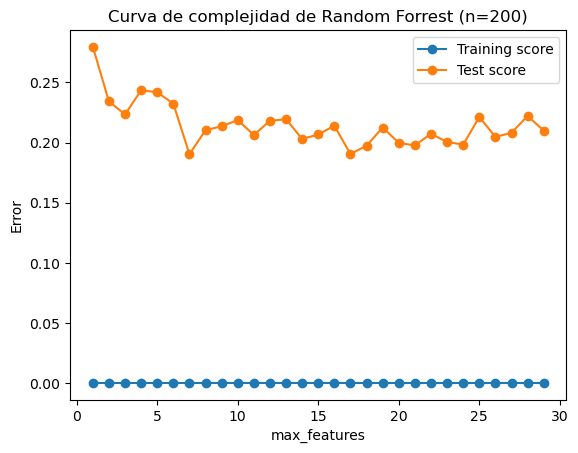

In [ ]:
# Curva de complejidad para el Random Forest

graficar_curva_complejidad (rf, X_train, y_train, "max_features", range(1,30), "Random Forrest (n=200)")


Training siempre constante en 0, disiminuye test error hasta aprox 13, a aprtir de ahi queda constante.
Aunque aumente max features, el gap queda constante.

heuristica indica que el optimo es cercano a np.sqrt(200 = features) = 14
0
más de 13 features, puede ser que ...

cuando hacemos boosting, una hipotesdis era que son modelos independientes. para eso, cada modelo ve cierta cantidad de features. con sqrt (features)

a prtir de ahi ruido

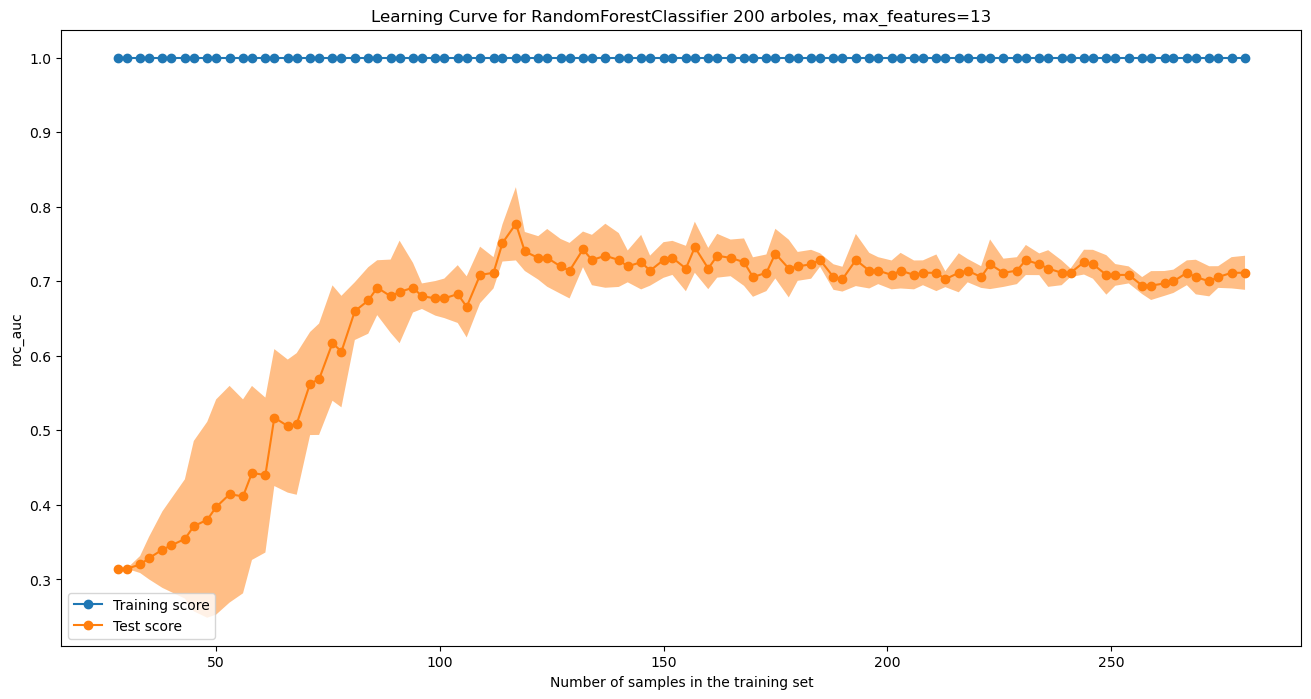

In [ ]:
#Learning curve 

bosques = [rf]

bosque_params = [" 200 arboles, max_features=13"]

plot_learning_curves(bosques, bosque_params)

Aprox en 110 alcanza el máximo y a partir de ahi parece quedar constante, por lo que más datos de entrnamiento no parecen mejorar el score. 

más datos queda igual es sesgo, pero la varianza parece disminuir un poco (se ve en la sombra marcada)

# 5. Predicciones

In [ ]:
#Obtenemos una predicción del roc_auc a partir de X_eval e y_eval

modelo_predicciones = clone(mejor_modelo_svm)
modelo_predicciones.set_params(probability = True)

roc_auc_score(y_eval, mejor_modelo_svm.predict_proba(X_eval)[:, 1])


0.8868002478826689

In [ ]:
#Obtenemos una predicción del roc_auc con Bootstrap  a partir de X_eval e y_eval

from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

np.random.seed(42)
n_bootstrap = 900
roc_auc_scores = []

for _ in range(n_bootstrap):
    X_bootstrap, y_bootstrap = resample(X_eval, y_eval)

    y_pred = mejor_modelo_svm.predict_proba(X_bootstrap)[:, 1]
    score = roc_auc_score(y_bootstrap, y_pred)
    roc_auc_scores.append(score)

roc_auc_scores = np.array(roc_auc_scores)

In [ ]:
roc_auc_scores.mean().round(4)

0.887

In [ ]:
#Obtenemos las predicciones del held_out

df_held_out = pd.read_csv('datos/X_held_out.csv').values

probabilidades_clase_1 = mejor_modelo_svm.predict_proba(df_held_out)[:, 1]

probabilidades_clase_1


array([2.52434488e-01, 8.34068368e-02, 6.45904176e-01, 2.78594424e-01,
       1.29718750e-01, 7.48521577e-02, 6.35003942e-02, 3.12586247e-01,
       1.76667233e-01, 3.54808404e-01, 4.84293772e-02, 1.01857977e-01,
       9.15284075e-02, 2.92508230e-02, 1.04081988e-01, 4.05509443e-02,
       2.07591402e-01, 6.68248829e-02, 3.10166521e-01, 9.63151794e-02,
       3.95224502e-02, 4.07758766e-02, 4.23641310e-02, 3.21378491e-01,
       5.59927768e-02, 9.88516909e-01, 3.28492129e-01, 4.70329771e-02,
       1.56046931e-01, 9.14615622e-01, 2.30789104e-01, 7.94745559e-01,
       7.91493521e-01, 1.04950097e-01, 7.68941144e-01, 7.32505293e-01,
       5.00000000e-01, 1.13901803e-01, 6.21651310e-01, 6.46535360e-02,
       8.11750182e-01, 2.20854284e-01, 3.92641282e-01, 2.56911050e-01,
       2.34107891e-02, 3.06989399e-01, 8.43194451e-02, 6.80612053e-02,
       1.04505217e-01, 1.00602087e-01, 7.84910647e-01, 1.47988146e-02,
       1.86455570e-01, 1.11191978e-01, 2.06254624e-01, 5.44916566e-01,
      

In [ ]:
#Guardamos en un archivo CSV con 4 decimales

df_output = pd.DataFrame(probabilidades_clase_1, columns=['output'])

df_output.to_csv('output.csv', index=False, float_format='%.4f')